In [2]:
import sys
import json
import gzip
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit import RDLogger
from joblib import Parallel, delayed

# Set up the system path to include parent directory
sys.path.append('../')

def configure_logging():
    """
    Configure RDKit logging to suppress warnings and errors.
    """
    lg = RDLogger.logger()
    lg.setLevel(RDLogger.ERROR)

def load_data(file_path):
    """
    Load the dataset from a CSV file.

    Args:
        file_path (str): Path to the CSV file.

    Returns:
        DataFrame: A pandas DataFrame containing the loaded data.
    """
    try:
        df = pd.read_csv(file_path)
        return df
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        sys.exit(1)

def main():
    """
    Main function to execute script tasks.
    """
    configure_logging()

    # Load data
    try:
        data_file_path = '../Data/USPTO_50k.csv'
        df = load_data(data_file_path)
    except:
        data_file_path = '/homes/biertank/tieu/Documents/Project/SynRBL/Data/USPTO_50K.csv'
        df = load_data(data_file_path)
    

    # Display the first few rows of the DataFrame
    display(df.head())

    # Print the number of rows in the DataFrame
    print(f"Number of rows in the dataset: {len(df)}")
    return df

if __name__ == "__main__":
    df = main()


,id,class,reactions
0,US05849732,6,COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(...
1,US20120114765A1,2,Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c...
2,US08003648B2,1,CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC...
3,US09045475B2,1,CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...
4,US08188098B2,2,CCOc1ccc(Oc2ncnc3c2cnn3C2CCNCC2)c(F)c1.O=C(Cl)...


Number of rows in the dataset: 50016


# **1. SynCleaning**

In [3]:
from SynRBL.SynCleaning import SMILESStandardizer
standardizer = SMILESStandardizer()
# Original SMILES strings for demonstration
original_smiles = [
    "C1=CC=CC=C1",  # Aromatic compound for dearomatization/aromatization
    "C1=CC=C2C(=C1)C=CC=C2",  # Tautomerizable compound
    "CC(C)(C)C(=O)O.O",  # Compound with a salt (water)
    "CC[NH+](CC)CC"  # Compound with charge
]

# **1. SynExtract**

Here's a brief description of how we can approach the task:

1. **Input and Parsing of Chemical Reactions**: The script will accept chemical reactions as input. Each reaction will be a string where reactants and products are separated by an arrow (e.g., A + B -> C + D). The script will parse these strings to identify reactants and products.

2. **Standardization of Chemical Formulas**: The script will standardize the chemical formulas to ensure consistency. This involves formatting element symbols and quantities properly.

3. **Decomposition into Molecular Formulas**: Each reactant and product will be broken down into its molecular formula. For example, decomposing H2O into {'H': 2, 'O': 1}.

4. **Labeling Types of Reactions**:

    - **Balance Check**: The script will check if the reaction is balanced by comparing the count of each element on both sides of the reaction.
    - **Labeling**: Based on the balance check, reactions will be labeled as:
        - **Balanced**: If the number of each type of atom is the same on both sides.
        - **Unbalanced in Reactants**: If any reactant element is not balanced.
        - **Unbalanced in Products**: If any product element is not balanced.
        - **Unbalanced in Both**: If elements in both reactants and products are unbalanced.

## **2.1. Extract SMILES**

In [6]:
from SynRBL.SynExtract.rsmi_processing import RSMIProcessing
process=RSMIProcessing(rsmi = df.loc[0,'reactions'])
process.smi_splitter()

['COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
 'COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O']

In [9]:
process=RSMIProcessing(data = df, rsmi_col='reactions',parallel=True, n_jobs=-1, save_json= True, save_path_name ='../Data/reaction.json.gz')
reactions = process.data_splitter()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 40944 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 50016 out of 50016 | elapsed:    2.1s finished


In [11]:
reactions

,id,class,reactions,reactants,products
0,US05849732,6,COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(...,COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(...,COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O
1,US20120114765A1,2,Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c...,Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c...,O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(C...
2,US08003648B2,1,CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC...,CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC...,CCN(CC)Cc1ccc(-c2nc(C)c(COc3ccc([C@H](CC(=O)N4...
3,US09045475B2,1,CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...,CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...,CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...
4,US08188098B2,2,CCOc1ccc(Oc2ncnc3c2cnn3C2CCNCC2)c(F)c1.O=C(Cl)...,CCOc1ccc(Oc2ncnc3c2cnn3C2CCNCC2)c(F)c1.O=C(Cl)...,CCOc1ccc(Oc2ncnc3c2cnn3C2CCN(C(=O)OC3CCCC3)CC2...
...,...,...,...,...,...
50011,US20140194411A1,9,CCOC(=O)N1CCc2ccc3c(c2CC1)C(O)(C1CC1)CC3>>CCOC...,CCOC(=O)N1CCc2ccc3c(c2CC1)C(O)(C1CC1)CC3,CCOC(=O)N1CCc2ccc3c(c2CC1)C(C1CC1)CC3
50012,US20090149445A1,9,Brc1cccc(C=C2c3ccccc3CCc3ccccc32)c1.N#C[Cu]>>N...,Brc1cccc(C=C2c3ccccc3CCc3ccccc32)c1.N#C[Cu],N#Cc1cccc(C=C2c3ccccc3CCc3ccccc32)c1
50013,US08710243B2,9,Cc1noc(C)c1-c1c(-c2ccc(O)cc2)c2ccccc2n1C=O.NO>...,Cc1noc(C)c1-c1c(-c2ccc(O)cc2)c2ccccc2n1C=O.NO,Cc1noc(C)c1-c1c(-c2ccc(O)cc2)c2ccccc2n1C=NO
50014,US20130303532A1,9,O=C(NC1CC1)c1ccc(-c2cnc3c(NCCCO)nc(Br)cn23)cc1...,O=C(NC1CC1)c1ccc(-c2cnc3c(NCCCO)nc(Br)cn23)cc1,O=C(NC1CC1)c1ccc(-c2cnc3c(NCCCO)nccn23)cc1


In [8]:
from SynRBL.rsmi_utils import load_database
reactions = load_database('../Data/reaction.json.gz')
reactions

[{'id': 'US05849732',
  'class': 6,
  'reactions': 'COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O>>COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
  'reactants': 'COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
  'products': 'COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O'},
 {'id': 'US20120114765A1',
  'class': 2,
  'reactions': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1>>O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1',
  'reactants': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1',
  'products': 'O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1'},
 {'id': 'US08003648B2',
  'class': 1,
  'reactions': 'CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC(=O)N2C(=O)OC[C@@H]2Cc2ccccc2)c2ccon2)cc1>>CCN(CC)Cc1ccc(-c2nc(C)c(COc3ccc([C@H](CC(=O)N4C(=O)OC[C@@H]4Cc4ccccc4)c4ccon4)cc3)s2)cc1',
  'reactants': 'CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC(=O)N2C(=O)OC[C@@H]2Cc2ccccc2)c2ccon2)cc1',
  '

## 2.2. Standardize SMILES

In [12]:
from SynRBL.SynCleaning import SMILESStandardizer
standardize = SMILESStandardizer()
reactions_standardized=standardize.standardize_dict_smiles(reactions,keys = ['reactants', 'products'], keep_mol=False,
                                                           normalize = True, tautomerize=True)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


[16:03:41] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 39 in file /Users/runner/work/rdkit-pypi/rdkit-pypi/build/temp.macosx-11.0-arm64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****

[16:03:41] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /Users/runner/work/rdkit-pypi/rdkit-pypi/build/temp.macosx-11.0-arm64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****

Tautomer enumeration stopped at maximum 1000
[Parallel(n_jobs=4)]: Done  99 tasks      | elapsed:    2.6s
Tautomer enumeration stopped at maximum 1000
[16:03:43] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line 52 in file /Users/runner/work/rdkit-pypi/rdkit-pypi/build/temp.macosx-11.0-arm64-cpython-39/rdkit/Code/GraphMol/RingInfo.cpp
Failed Expression: df_init
****

[16:03:43] 

****
Pre-condition Violation
RingInfo not initialized
Violation occurred on line

KeyboardInterrupt: 

In [16]:
reactions_standardized[0]

[{'id': 'US05849732',
  'class': 6,
  'reactions': 'COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O>>COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
  'reactants': 'COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
  'products': 'COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
  'standardized_reactants': 'COC(=O)C(CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O'},
 {'id': 'US20120114765A1',
  'class': 2,
  'reactions': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1>>O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1',
  'reactants': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1',
  'products': 'O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1',
  'standardized_reactants': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1'},
 {'id': 'US08003648B2',
  'class': 1,
  'reactions': 'CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC(=O)N2C(=O)OC[C@@H]2Cc2ccccc2)c2ccon2)cc1>>CCN(CC)Cc1ccc(-c

## **2.3. Molecular Decomposer**

In [13]:
from SynRBL.SynExtract import RSMIDecomposer  

In [14]:
decompose = RSMIDecomposer(smiles=None, data=reactions, reactant_col='reactants', product_col='products', parallel=True, n_jobs=-1, verbose=1)
react_dict, product_dict = decompose.data_decomposer()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 40944 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 50016 out of 50016 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 40944 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 50016 out of 50016 | elapsed:    1.8s finished


## **2.4. Molecular Comparator**

In [15]:
from SynRBL.SynExtract.rsmi_comparator import RSMIComparator
from SynRBL.rsmi_utils import *
import pandas as pd

In [16]:
comp = RSMIComparator(reactants= react_dict, products=product_dict, n_jobs=-1)
unbalance , diff_formula= comp.run_parallel()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 45062 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 50016 out of 50016 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 45062 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 50016 out of 50016 | elapsed:    0.2s finished


In [17]:
reactions_clean = pd.concat([pd.DataFrame(reactions), pd.DataFrame([unbalance]).T.rename(columns={0:'Unbalance'}),
           pd.DataFrame([diff_formula]).T.rename(columns={0:'Diff_formula'})], axis=1).to_dict(orient='records')

reactions_clean

[{'id': 'US05849732',
  'class': 6,
  'reactions': 'COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O>>COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
  'reactants': 'COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
  'products': 'COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O',
  'Unbalance': 'Products',
  'Diff_formula': {'C': 8, 'O': 2, 'H': 6}},
 {'id': 'US20120114765A1',
  'class': 2,
  'reactions': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1>>O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1',
  'reactants': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1',
  'products': 'O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1',
  'Unbalance': 'Products',
  'Diff_formula': {'O': 1, 'H': 2}},
 {'id': 'US08003648B2',
  'class': 1,
  'reactions': 'CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC(=O)N2C(=O)OC[C@@H]2Cc2ccccc2)c2ccon2)cc1>>CCN(CC)Cc1ccc(-c2nc(C)c(COc3ccc([C@H](CC(=O)N4C(=O)OC[C@@H]4Cc4ccc

In [18]:
save_database(reactions_clean, '../Data/reaction_clean.json.gz')

# **3. SynRuleEngine - Rule Generation**

## 3.1. Basic rule

In [43]:
from SynRBL.rsmi_utils import save_database, load_database, filter_data, sort_by_key_length
from SynRBL.SynRuleEngine.rule_data_manager import RuleImputeManager
rules = load_database('../Data/Rules/rules_manager.json.gz')
former_len = len(rules)
db = RuleImputeManager(rules)
entries = [{'formula': 'CO2', 'smiles': 'C=O'}, {'formula': 'Invalid', 'smiles': 'Invalid'}]
invalid_entries = db.add_entries(entries)
print(f"Invalid entries: {invalid_entries}")

rules = filter_data(all, formula_key='Composition',element_key='C', min_count=0, max_count=1)
rules = sort_by_key_length(rules, lambda x: x['Composition'])

if len(rules) > former_len:
    save_database(rules, '../Data/Rules/rules_manager.json.gz')

else:
    print("Not saved")



Invalid entries: [{'formula': 'CO2', 'smiles': 'C=O'}, {'formula': 'Invalid', 'smiles': 'Invalid'}]
Not saved


[11:43:27] SMILES Parse Error: syntax error while parsing: Invalid
[11:43:27] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'


In [1]:
import sys
sys.path.append('../')

from SynRBL.rsmi_utils import *
from SynRBL.SynRuleEngine.rule_data_manager import RuleImputeManager
reactions_clean = load_database('../Data/reaction_clean.json.gz')

In [34]:
rules = filter_data(all, formula_key='Composition',element_key='C', min_count=0, max_count=1)
rules = sort_by_key_length(rules, lambda x: x['Composition'])
save_database(rules, '../Data/Rules/rules_manager.json.gz')
rules

[{'formula': 'Cl2', 'smiles': 'ClCl', 'Composition': {'Cl': 2, 'Q': 0}},
 {'formula': 'N3-',
  'smiles': '[N-]=[N+]=[N-]',
  'Composition': {'N': 3, 'Q': -1}},
 {'formula': 'H2', 'smiles': '[HH]', 'Composition': {'Q': 0, 'H': 2}},
 {'formula': 'F2', 'smiles': 'FF', 'Composition': {'Q': 0, 'F': 2}},
 {'formula': 'Cl2', 'smiles': 'ClCl', 'Composition': {'Q': 0, 'Cl': 2}},
 {'formula': 'Br2', 'smiles': 'BrBr', 'Composition': {'Q': 0, 'Br': 2}},
 {'formula': 'I2', 'smiles': 'II', 'Composition': {'Q': 0, 'I': 2}},
 {'formula': 'H+', 'smiles': '[H+]', 'Composition': {'Q': 1, 'H': 1}},
 {'formula': 'Na+', 'smiles': '[Na+]', 'Composition': {'Q': 1, 'Na': 1}},
 {'formula': 'Li+', 'smiles': '[Li+]', 'Composition': {'Q': 1, 'Li': 1}},
 {'formula': 'K+', 'smiles': '[K+]', 'Composition': {'Q': 1, 'K': 1}},
 {'formula': 'Ca2+', 'smiles': '[Ca+2]', 'Composition': {'Q': 2, 'Ca': 1}},
 {'formula': 'Mg2+', 'smiles': '[Mg+2]', 'Composition': {'Q': 2, 'Mg': 1}},
 {'formula': 'Ba2+', 'smiles': '[Ba+2]', 'C

In [15]:
len(rules)

281

In [40]:
db = RuleImputeManager(rules)
entries = [{'formula': 'CO2', 'smiles': 'C=O'}, {'formula': 'Invalid', 'smiles': 'Invalid'}]
invalid_entries = db.add_entries(entries)
print(f"Invalid entries: {invalid_entries}")

Invalid entries: [{'formula': 'CO2', 'smiles': 'C=O'}, {'formula': 'Invalid', 'smiles': 'Invalid'}]


[11:40:02] SMILES Parse Error: syntax error while parsing: Invalid
[11:40:02] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'


In [17]:
from SynRBL.rsmi_utils import save_database
save_database(rules, '../Data/Rules/rules_manager.json.gz')

In [4]:
# Test case
import pandas as pd

# Without an existing database and add one entry
db = RuleImputeManager()
try:
    db.add_entry('H2O', 'O')
except ValueError as e:
    print(e)

# With an existing list of dictionaries
existing_database = [{'formula': 'H2O', 'smiles': 'O','composition': {1: 2, 8: 1}}]
db = RuleImputeManager(existing_database)
entries = [{'formula': 'CO2', 'smiles': 'C=O'}, {'formula': 'Invalid', 'smiles': 'Invalid'}]
invalid_entries = db.add_entries(entries)
print(f"Invalid entries: {invalid_entries}")

# With an existing pandas DataFrame
existing_dataframe = pd.DataFrame([{'formula': 'H2O', 'smiles': 'O', 'composition': {1: 2, 8: 1}}])
db = RuleImputeManager(existing_dataframe)
entries = [{'formula': 'CO2', 'smiles': 'C=O'}, {'formula': 'Invalid', 'smiles': 'Invalid'}]
invalid_entries = db.add_entries(entries)
print(f"Invalid entries: {invalid_entries}")

# Without an existing database
db = RuleImputeManager()
entries = [{'formula': 'H2O', 'smiles': 'O'}, {'formula': 'Invalid', 'smiles': 'Invalid'}]
invalid_entries = db.add_entries(entries)
print(f"Invalid entries: {invalid_entries}")


Entry with formula 'H2O' and smiles 'O' added to the database.
Entry with formula 'CO2' and smiles 'C=O' added to the database.
Invalid entries: [{'formula': 'Invalid', 'smiles': 'Invalid'}]
Entry with formula 'CO2' and smiles 'C=O' added to the database.
Invalid entries: [{'formula': 'Invalid', 'smiles': 'Invalid'}]
Entry with formula 'H2O' and smiles 'O' added to the database.
Invalid entries: [{'formula': 'Invalid', 'smiles': 'Invalid'}]


[11:16:42] SMILES Parse Error: syntax error while parsing: Invalid
[11:16:42] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[11:16:42] SMILES Parse Error: syntax error while parsing: Invalid
[11:16:42] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'
[11:16:42] SMILES Parse Error: syntax error while parsing: Invalid
[11:16:42] SMILES Parse Error: Failed parsing SMILES 'Invalid' for input: 'Invalid'


In [9]:
existing_database = [{'formula': 'H2O', 'smiles': 'O','composition': {'H': 2, 'O': 1}}]
db = RuleImputeManager(existing_database)
entries = [{'formula': 'CO2', 'smiles': 'C=O'}]
invalid_entries = db.add_entries(entries)
print(f"Invalid entries: {invalid_entries}")

Entry with formula 'CO2' and smiles 'C=O' added to the database.
Invalid entries: []


In [10]:
existing_database

[{'formula': 'H2O', 'smiles': 'O', 'composition': {'H': 2, 'O': 1}},
 {'formula': 'CO2',
  'smiles': 'C=O',
  'Composition': {'C': 1, 'O': 1, 'H': 2, 'Q': 0}}]

In [8]:
existing_database

[{'formula': 'H2O', 'smiles': 'O', 'composition': {1: 2, 8: 1}},
 {'formula': 'CO2',
  'smiles': 'C=O',
  'Composition': {'C': 1, 'O': 1, 'H': 2, 'Q': 0}}]

## 3.2. Inference rule

- Working to integrate rule_inference in section 4 - matching and impute

In [18]:
from SynRBL.SynRuleEngine.domain_knowledge_rules import infer_chemical_rule_for_imputation
reaction_list = []
new_reaction = infer_chemical_rule_for_imputation(rule_dict={"O":1}, smiles_reactants='[HH]', reactants_ratio=1, 
                                                  smiles_products='[OH-].[H+]', products_ratio=1, reaction_list=reaction_list)

new_reaction


[[{'rule_dict': {'O': 1},
   'smiles_reactants': '[HH]',
   'reactants_ratio': 1,
   'smiles_products': '[OH-].[H+]',
   'products_ratio': 1}]]

## 2.3. Automatic rule extraction

In [13]:
import sys
import gzip
import json
sys.path.append('../')
from SynRBL.SynRuleEngine import AutomaticSmilesExtraction, AutomaticRulesExtraction
from SynRBL.rsmi_utils import load_database
reactions = load_database('../Data/reaction.json.gz')


# Create an instance of the AutomaticSmilesExtraction class with parallel processing
smi_extractor = AutomaticSmilesExtraction(reactions, n_jobs=-1, verbose=1)

# Example usage of get_fragments
input_dict = {
    'smiles': smi_extractor.smiles_list,
    'mw': smi_extractor.mw,
    'n_C': smi_extractor.n_C
}
filtered_fragments = AutomaticSmilesExtraction.get_fragments(input_dict, mw=500, n_C=0, combination='intersection')
print("Filtered Fragments:", len(filtered_fragments))


extractor = AutomaticRulesExtraction(existing_database=[], n_jobs=-1, verbose=1)
extractor.add_new_entries(filtered_fragments)
automated_rules = extractor.extract_rules()
print("Extracted Rules:", len(automated_rules))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 49136 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 135605 out of 135605 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 49136 tasks      | elapsed:    0.9s


Filtered Fragments: 3
Entry with formula 'H3N' and smiles 'N' added to the database.
Entry with formula 'H2O' and smiles 'O' added to the database.
Entry with formula 'N3-' and smiles '[N-]=[N+]=[N-]' added to the database.
Entry with formula 'H4N2' and smiles 'NN' added to the database.
Entry with formula 'HO4S-' and smiles 'O=S([O-])OO' added to the database.
Entry with formula 'H3NO' and smiles 'NO' added to the database.
Entry with formula 'H4N+' and smiles '[NH4+]' added to the database.
Entry with formula 'HI' and smiles 'I' added to the database.
Entry with formula 'H2O2' and smiles 'OO' added to the database.
Entry with formula 'H4N2O2S' and smiles 'NS(N)(=O)=O' added to the database.
Entry with formula 'HBr' and smiles 'Br' added to the database.
Entry with formula 'HClO3S' and smiles 'O=S(=O)(O)Cl' added to the database.
Entry with formula 'HCl' and smiles 'Cl' added to the database.
Entry with formula 'Cl2O2S' and smiles 'O=S(=O)(Cl)Cl' added to the database.
Entry with form

[Parallel(n_jobs=-1)]: Done 135605 out of 135605 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1190 out of 1190 | elapsed:    0.0s finished


In [11]:
filtered_fragments

{'smiles': ['CCNCC',
  'O=C(CF)CF',
  'COC(=O)CN',
  'O=Cc1c[nH]cn1',
  'CC(C)S',
  'C[O-]',
  'N',
  'C=CC(C)=O',
  'C=O',
  'CNC',
  'CC(=O)Cl',
  'CNC',
  'C#CC1CC1',
  'CCN',
  'NCCC1CC1',
  'CN=C=O',
  'C=CC(=O)Cl',
  'Cn1cc(N)cn1',
  'N',
  'CCN=C=S',
  'CCOCCO',
  'C=O',
  'OC(CF)CF',
  'Nc1nnn[nH]1',
  'CC(=O)Cl',
  'CC(C)O',
  'F[C@@H]1CCNC1',
  'C=O',
  'CN',
  'NC(N)=S',
  'NC1CCCC1',
  'CN(C)C=O',
  'O=C1CCNCC1',
  'C1COCCN1',
  'NCCCl',
  'CC(C)(C)O',
  'CC(C)CC=O',
  'C=CC[C@@H](C)O',
  'Nc1ccccc1',
  'Nc1nnn[nH]1',
  'NC1CC1',
  'CC(C)=O',
  'CC(=O)O',
  'O',
  'C=O',
  'C#C[Si](C)(C)C',
  'N=C(N)N',
  'CNC',
  'CO',
  'CCN',
  '[N-]=[N+]=[N-]',
  '[N-]=[N+]=[N-]',
  'CS(N)(=O)=O',
  'C1CCNC1',
  'C1CNCCN1',
  'N#CCN',
  'CC(=O)Cl',
  'CCN',
  'N#CCCCl',
  'CCN',
  'COCCO',
  '[C-]#N',
  'CCN',
  'CC(=O)Cl',
  'C1CNCCN1',
  'N#C[Cu]',
  'CO',
  'NN',
  'CN',
  'O=S([O-])OO',
  'C#C[Si](C)(C)C',
  'CC(=O)O',
  'CS(N)(=O)=O',
  'CN',
  'C#C[Si](C)(C)C',
  'CN(C)C=O',
  'CC

In [10]:
automated_rules

[{'formula': 'C4H11N',
  'smiles': 'CCNCC',
  'Composition': {'C': 4, 'N': 1, 'H': 11, 'Q': 0}},
 {'formula': 'C3H4F2O',
  'smiles': 'O=C(CF)CF',
  'Composition': {'O': 1, 'C': 3, 'F': 2, 'H': 4, 'Q': 0}},
 {'formula': 'C3H7NO2',
  'smiles': 'COC(=O)CN',
  'Composition': {'C': 3, 'O': 2, 'N': 1, 'H': 7, 'Q': 0}},
 {'formula': 'C4H4N2O',
  'smiles': 'O=Cc1c[nH]cn1',
  'Composition': {'O': 1, 'C': 4, 'N': 2, 'H': 4, 'Q': 0}},
 {'formula': 'C3H8S',
  'smiles': 'CC(C)S',
  'Composition': {'C': 3, 'S': 1, 'H': 8, 'Q': 0}},
 {'formula': 'CH3O-',
  'smiles': 'C[O-]',
  'Composition': {'C': 1, 'O': 1, 'H': 3, 'Q': -1}},
 {'formula': 'H3N', 'smiles': 'N', 'Composition': {'N': 1, 'H': 3, 'Q': 0}},
 {'formula': 'C4H6O',
  'smiles': 'C=CC(C)=O',
  'Composition': {'C': 4, 'O': 1, 'H': 6, 'Q': 0}},
 {'formula': 'CH2O',
  'smiles': 'C=O',
  'Composition': {'C': 1, 'O': 1, 'H': 2, 'Q': 0}},
 {'formula': 'C2H7N',
  'smiles': 'CNC',
  'Composition': {'C': 2, 'N': 1, 'H': 7, 'Q': 0}},
 {'formula': 'C2H3C

In [7]:
# Create an instance of the AutomaticSmilesExtraction class with parallel processing
smi_extractor = AutomaticSmilesExtraction(reactions, n_jobs=-1, verbose=1)

# Example usage of get_fragments
input_dict = {
    'smiles': smi_extractor.smiles_list,
    'mw': smi_extractor.mw,
    'n_C': smi_extractor.n_C
}
filtered_fragments = AutomaticSmilesExtraction.get_fragments(input_dict, mw=100, n_C=0, combination='union')
print("Filtered Fragments:", len(filtered_fragments))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 49136 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 135605 out of 135605 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 49136 tasks      | elapsed:    1.0s


Filtered Fragments: 3


[Parallel(n_jobs=-1)]: Done 135605 out of 135605 | elapsed:    2.6s finished


In [8]:
extractor = AutomaticRulesExtraction(existing_database=[], n_jobs=-1, verbose=1)
extractor.add_new_entries(filtered_fragments)
rules = extractor.extract_rules()
print("Extracted Rules:", rules)

Entry with formula 'C4H11N' and smiles 'CCNCC' added to the database.
Entry with formula 'C3H4F2O' and smiles 'O=C(CF)CF' added to the database.
Entry with formula 'C3H7NO2' and smiles 'COC(=O)CN' added to the database.
Entry with formula 'C4H4N2O' and smiles 'O=Cc1c[nH]cn1' added to the database.
Entry with formula 'C3H8S' and smiles 'CC(C)S' added to the database.
Entry with formula 'CH3O-' and smiles 'C[O-]' added to the database.
Entry with formula 'H3N' and smiles 'N' added to the database.
Entry with formula 'C4H6O' and smiles 'C=CC(C)=O' added to the database.
Entry with formula 'CH2O' and smiles 'C=O' added to the database.
Entry with formula 'C2H7N' and smiles 'CNC' added to the database.
Entry with formula 'C2H3ClO' and smiles 'CC(=O)Cl' added to the database.
Entry with formula 'C5H6' and smiles 'C#CC1CC1' added to the database.
Entry with formula 'C5H11N' and smiles 'NCCC1CC1' added to the database.
Entry with formula 'C2H3NO' and smiles 'CN=C=O' added to the database.
Entr

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 8376 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 8596 out of 8611 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 8611 out of 8611 | elapsed:    0.1s finished


In [6]:
rules

[{'formula': 'C9H8N2',
  'smiles': 'Nc1cccc2cnccc12',
  'Composition': {'N': 2, 'C': 9, 'H': 8, 'Q': 0}},
 {'formula': 'C10H4Cl2N2O4S2',
  'smiles': 'O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1',
  'Composition': {'O': 4, 'C': 10, 'N': 2, 'S': 2, 'Cl': 2, 'H': 4, 'Q': 0}},
 {'formula': 'C4H11N',
  'smiles': 'CCNCC',
  'Composition': {'C': 4, 'N': 1, 'H': 11, 'Q': 0}},
 {'formula': 'C3H4F2O',
  'smiles': 'O=C(CF)CF',
  'Composition': {'O': 1, 'C': 3, 'F': 2, 'H': 4, 'Q': 0}},
 {'formula': 'C6H9ClO2',
  'smiles': 'O=C(Cl)OC1CCCC1',
  'Composition': {'O': 2, 'C': 6, 'Cl': 1, 'H': 9, 'Q': 0}},
 {'formula': 'C10H7BrN4',
  'smiles': 'Cn1cnc(-c2cc(C#N)ccn2)c1Br',
  'Composition': {'C': 10, 'N': 4, 'Br': 1, 'H': 7, 'Q': 0}},
 {'formula': 'C9H9BN2O2',
  'smiles': 'OB(O)c1ccc(-n2cccn2)cc1',
  'Composition': {'O': 2, 'B': 1, 'C': 9, 'N': 2, 'H': 9, 'Q': 0}},
 {'formula': 'C5H12N2O2',
  'smiles': 'CC(C)(C)OC(=O)NN',
  'Composition': {'C': 5, 'O': 2, 'N': 2, 'H': 12, 'Q': 0}},
 {'formula': 'C7H4Br

In [82]:
len(rules)

7865

In [83]:
domain_rules = load_database('../Data/rule_manager.json.gz')
rules.extend(domain_rules)
len(rules)

7921

In [9]:
from SynRBL.rsmi_utils import remove_duplicates_by_key, sort_by_key_length
# Remove duplicates
unique_data = remove_duplicates_by_key(rules, lambda x: frozenset(x['Composition'].items()))

# Sort by length of 'Diff_formula'
auto_rules = sort_by_key_length(unique_data, lambda x: x['Composition'])
len(auto_rules)


7865

In [12]:
new_auto_rules = add_missing_key_to_dicts(auto_rules, 'Composition', 'Q', 0)
len(new_auto_rules)

7865

In [89]:
from SynRBL.rsmi_utils import save_database
save_database(auto_rules, '../Data/automatic_rules.json.gz')

# **4. SynRuleImpute**


## 4.1. Rule Matcher

In [1]:
from SynRBL.rsmi_utils import *
import pandas as pd
import numpy as np

ModuleNotFoundError: No module named 'SynRBL'

In [14]:
data = pd.DataFrame(load_database('../Data/reaction_clean.json.gz'))
data = data[(data['Unbalance']=='Products')|(data['Unbalance']=='Reactants')]
df = pd.DataFrame(data['Diff_formula'].to_list())
df.index = data.index
df['Total missing atoms'] = df.drop(columns=['Q']).sum(axis=1)
df['Number of atomic missing'] = df.drop(columns=['Q', 'Total missing atoms']).notnull().sum(axis=1)


In [15]:
#one = data[df['Number of atomic missing']==1].to_dict('records')
test = data[(df['Number of atomic missing']<3)].to_dict('records')
Diff_formula = pd.DataFrame(test).loc[:,'Diff_formula'].to_list()
len(Diff_formula)

35055

In [16]:
rules = load_database('../Data/automatic_rules.json.gz')

In [17]:
from SynRBL.rsmi_utils import extract_atomic_elements, _get_max_comp_len, build_lookups
atomic = extract_atomic_elements(rules)
len(atomic)
max_comp_len = _get_max_comp_len(rules)
max_comp_len
lookup =build_lookups(atomic, rules)

In [15]:
all = load_database('../Data/three_atomic_database.json.gz')

In [17]:
all[0].keys()

dict_keys(['formula', 'smiles', 'Composition'])

In [14]:
from SynRBL.rsmi_utils import filter_data
help(filter_data)

Help on function filter_data in module SynRBL.rsmi_utils:

filter_data(data: List[Dict[str, <built-in function any>]], unbalance_values: Optional[List[str]] = None, formula_key: str = 'Diff_formula', element_key: Optional[str] = None, min_count: int = 0, max_count: int = 3) -> List[Dict[str, <built-in function any>]]
    Filter dictionaries based on a list of unbalance values and element count in a specified formula key.
    
    This function filters the input list of dictionaries based on the specified list of unbalance values and
    the count of a specific element within a given formula key. It returns dictionaries that match any of the
    unbalance criteria and where the element count falls within the specified range.
    
    Args:
        data: A list of dictionaries to be filtered.
        unbalance_values: The values to filter by in the 'Unbalance' key. If None, this criterion is ignored.
        formula_key: The key in the dictionaries that contains the element counts. Defau

In [33]:
rules = filter_data(all, formula_key='Composition',element_key='C', min_count=0, max_count=1)
rules = sort_by_key_length(rules, lambda x: x['Composition'])
save_database(rules, '../Data/Rules/rules_manager.json.gz')
rules

[{'formula': 'Cl2', 'smiles': 'ClCl', 'Composition': {'Cl': 2, 'Q': 0}},
 {'formula': 'N3-',
  'smiles': '[N-]=[N+]=[N-]',
  'Composition': {'N': 3, 'Q': -1}},
 {'formula': 'H2', 'smiles': '[HH]', 'Composition': {'Q': 0, 'H': 2}},
 {'formula': 'F2', 'smiles': 'FF', 'Composition': {'Q': 0, 'F': 2}},
 {'formula': 'Cl2', 'smiles': 'ClCl', 'Composition': {'Q': 0, 'Cl': 2}},
 {'formula': 'Br2', 'smiles': 'BrBr', 'Composition': {'Q': 0, 'Br': 2}},
 {'formula': 'I2', 'smiles': 'II', 'Composition': {'Q': 0, 'I': 2}},
 {'formula': 'H+', 'smiles': '[H+]', 'Composition': {'Q': 1, 'H': 1}},
 {'formula': 'Na+', 'smiles': '[Na+]', 'Composition': {'Q': 1, 'Na': 1}},
 {'formula': 'Li+', 'smiles': '[Li+]', 'Composition': {'Q': 1, 'Li': 1}},
 {'formula': 'K+', 'smiles': '[K+]', 'Composition': {'Q': 1, 'K': 1}},
 {'formula': 'Ca2+', 'smiles': '[Ca+2]', 'Composition': {'Q': 2, 'Ca': 1}},
 {'formula': 'Mg2+', 'smiles': '[Mg+2]', 'Composition': {'Q': 2, 'Mg': 1}},
 {'formula': 'Ba2+', 'smiles': '[Ba+2]', 'C

In [19]:
# Define the test cases with their expected results
test_cases = [
    #{'Q': 0, 'H': 2, 'Expected': 'H2'},  # Should result in H2
    {'Q': 0, 'H': 2, 'O':0, 'Expected': 'H2'},  # Should result in H2
    {'O': 2, 'Expected': 'O2'},  # Should result in O2
    {'Q': 0, 'F': 2, 'Expected': 'F2'},  # Should result in F2
    {'Q': 0, 'Cl': 2, 'Expected': 'Cl2'},  # Should result in Cl2
    {'Q': 0, 'Br': 2, 'Expected': 'Br2'},  # Should result in Br2
    {'Q': 0, 'I': 2, 'Expected': 'I2'},  # Should result in I2
    {'Q': -1, 'F': 1, 'Expected': 'F-'},  # Should result in F-
    {'Q': -1, 'Cl': 1, 'Expected': 'Cl-'},  # Should result in Cl-
    {'Q': -1, 'Br': 1, 'Expected': 'Br-'},  # Should result in Br-
    {'Q': -1, 'I': 1, 'Expected': 'I-'},  # Should result in I-
    {'Q': 0, 'N': 2, 'Expected': 'N2'},  # Should result in N2
    {'Q': 1, 'H': 1, 'Expected': 'H+'},  # Should result in H+
    {'Q': -2, 'C': 1, 'O': 3, 'Expected': 'CO3--'},  # Should result in CO3--
    {'Q': -1, 'N': 1, 'H': 2, 'Expected': 'NH2-'},  # Should result in NH2-
    {'Q': -1, 'N': 1, 'O': 2, 'Expected': 'NO2-'},  # Should result in NO2-
    {'Q': -1, 'H': 1, 'S': 1, 'Expected': 'HS-'},  # Should result in HS-
    {'Q': 0, 'H': 2, 'S': 1, 'Expected': 'H2S'},  # Should result in H2S
    {'Q': 0, 'H': 2, 'S': 1, 'Expected': 'H2S'},  # Should result in H2S
    {'Q': -2, 'S': 1, 'O': 4, 'Expected': 'SO4^2-'},  # Should result in SO4^2-
    {'Q': 0, 'H': 2, 'Na': 2, 'O': 2, 'Expected': '2 NaOH'},  # Should result in 2 NaOH (Na+ and OH- examples)
    {'Q': 0, 'Li': 1, 'F': 1, 'Expected': 'Li+ and F-'},  # Should result in Li+ and F-
    {'Q': 0, 'C': 1, 'H': 4, 'Expected': 'CH4'},  # Should result in CH4
    {'Q': 1, 'N': 1, 'H': 4, 'Expected': 'NH4+'},  # Should result in NH4+
    {'Q': 0, 'C': 2, 'H': 2, 'Expected': 'C2H2'},  # Should result in C2H2
    {'Q': -1, 'C': 2, 'H': 1, 'Expected': 'C2H-'},  # Should result in C2H-
    {'Q': 0, 'C': 2, 'H': 4, 'Expected': 'C2H4'},  # Should result in C2H4
    {'Q': 0, 'C': 2, 'H': 6, 'Expected': 'C2H6'},  # Should result in C2H6
    {'Q': 0, 'C': 3, 'H': 4, 'Expected': 'C3H4'},  # Should result in C3H4
    {'Q': 0, 'C': 3, 'H': 8, 'Expected': 'C3H8'},  # Should result in C3H8
    {'Q': 0, 'C': 4, 'H': 10, 'Expected': 'nC4H10'},  # Should result in nC4H10
    {'Q': 0, 'C': 1, 'H': 4, 'Expected': 'CH4'},  # Should result in CH4
    {'Q': 0, 'C': 6, 'H': 6, 'Expected': 'C6H6'},  # Should result in C6H6
    {'Q': 0, 'C': 4, 'H': 8, 'Expected': 'C4H8'},  # Should result in C4H8
]


In [34]:
rule_dict = [
    {"formula": "H2", "smiles": "[HH]", "Composition": {"Q": 0, "H": 2}},
    {"formula": "F2", "smiles": "FF", "Composition": {"Q": 0, "F": 2}},
    {"formula": "Cl2", "smiles": "ClCl", "Composition": {"Q": 0, "Cl": 2}},
    {"formula": "Br2", "smiles": "BrBr", "Composition": {"Q": 0, "Br": 2}},
    {"formula": "I2", "smiles": "II", "Composition": {"Q": 0, "I": 2}},
    {"formula": "H+", "smiles": "[H+]", "Composition": {"Q": 1, "H": 1}},
    {"formula": "Na+", "smiles": "[Na+]", "Composition": {"Q": 1, "Na": 1}},
    {"formula": "Li+", "smiles": "[Li+]", "Composition": {"Q": 1, "Li": 1}},
    {"formula": "K+", "smiles": "[K+]", "Composition": {"Q": 1, "K": 1}},
    {"formula": "Ca2+", "smiles": "[Ca+2]", "Composition": {"Q": 2, "Ca": 1}},
    {"formula": "Mg2+", "smiles": "[Mg+2]", "Composition": {"Q": 2, "Mg": 1}},
    {"formula": "Ba2+", "smiles": "[Ba+2]", "Composition": {"Q": 2, "Ba": 1}},
    {"formula": "Al3+", "smiles": "[Al+3]", "Composition": {"Q": 3, "Al": 1}},
    {"formula": "Zn2+", "smiles": "[Zn+2]", "Composition": {"Q": 2, "Zn": 1}},
    {"formula": "Cu2+", "smiles": "[Cu+2]", "Composition": {"Q": 2, "Cu": 1}},
    {"formula": "Cu+", "smiles": "[Cu+]", "Composition": {"Q": 1, "Cu": 1}},
    {"formula": "F-", "smiles": "[F-]", "Composition": {"Q": -1, "F": 1}},
    {"formula": "Cl-", "smiles": "[Cl-]", "Composition": {"Q": -1, "Cl": 1}},
    {"formula": "Br-", "smiles": "[Br-]", "Composition": {"Q": -1, "Br": 1}},
    {"formula": "I-", "smiles": "[I-]", "Composition": {"Q": -1, "I": 1}},
    {"formula": "N2", "smiles": "N#N", "Composition": {"Q": 0, "N": 2}},
    {"formula": "O2", "smiles": "O=O", "Composition": {"Q": 0, "O": 2}},
    {"formula": "S^2-", "smiles": "[S^2-]", "Composition": {"Q": -2, "S": 1}},
    {"formula": "H2S", "smiles": "H2S", "Composition": {"Q": 0, "H":2, "S": 1}},
    {"formula": "HS-", "smiles": "[H][S-]", "Composition": {"Q": -1, "H":1, "S": 1}},
    {"formula": "OH-", "smiles": "[OH-]", "Composition": {"Q": -1, "H": 1, "O": 1}},
    {"formula": "NH3", "smiles": "N", "Composition": {"Q": 0, "H": 3, "N": 1}},
    {"formula": "NO2-", "smiles": "O=N[O-]", "Composition": {"Q": -1, "O": 2, "N": 1}},
    {"formula": "NO3-", "smiles": "[N+](=O)([O-])[O-]", "Composition": {"Q": -1, "O": 3, "N": 1}},
    {"formula": "NH2-", "smiles": "[NH2-]", "Composition": {"Q": -1, "H": 2, "N": 1}},
    {"formula": "CH4", "smiles": "C", "Composition": {"Q": 0, "H": 4, "C": 1}},
    {"formula": "C2H6", "smiles": "CC", "Composition": {"Q": 0, "H": 6, "C": 2}},
    {"formula": "C2H4", "smiles": "C=C", "Composition": {"Q": 0, "H": 4, "C": 2}},
    {"formula": "C2H2", "smiles": "C#C", "Composition": {"Q": 0, "H": 2, "C": 2}},
    {"formula": "C2H-", "smiles": "[C-]#C", "Composition": {"Q": -1, "H": 1, "C": 2}},
    {"formula": "C3H8", "smiles": "CCC", "Composition": {"Q": 0, "H": 8, "C": 3}},
    {"formula": "nC3H6", "smiles": "C=CC", "Composition": {"Q": 0, "H": 6, "C": 3}},
    {"formula": "cC3H6", "smiles": "C1CC1", "Composition": {"Q": 0, "H": 6, "C": 3}},
    {"formula": "nC4H10", "smiles": "C=CCC", "Composition": {"Q": 0, "C": 4, "H": 8}},
    {"formula": "nC4H8", "smiles": "C=C(C)C", "Composition": {"Q": 0, "C": 4, "H": 8}},
    {"formula": "iC4H10", "smiles": "CCCC", "Composition": {"Q": 0, "C": 4, "H": 10}},
    {"formula": "iC4H10", "smiles": "CC(C)C", "Composition": {"Q": 0, "C": 4, "H": 10}},
    {"formula": "C3H4", "smiles": "C#CC", "Composition": {"Q": 0, "H": 4, "C": 3}},
    {"formula": "C6H6", "smiles": "c1ccccc1", "Composition": {"Q": 0, "C": 6, "H": 6}},
    {"formula": "C7H8", "smiles": "Cc1ccccc1", "Composition": {"Q": 0, "C": 7, "H": 8}},
    {"formula": "CO2", "smiles": "O=C=O", "Composition": {"Q": 0, "C": 1, "O": 2}},
    {"formula": "[CO3]2-", "smiles": "O=C([O-])[O-]", "Composition": {"Q": -2, "C": 1, "O": 3}},
    {"formula": "SO4^2-", "smiles": "[SO4^2-]", "Composition": {"Q": -2, "S": 1, "O": 4}},
    {"formula": "NO3-", "smiles": "[NO3-]", "Composition": {"Q": -1, "N": 1, "O": 3}},
    {"formula": "PO4^3-", "smiles": "[PO4^3-]", "Composition": {"Q": -3, "P": 1, "O": 4}},
     {"formula": "CH3OH", "smiles": "CO", "Composition": {"Q": 0, "C": 1, "H": 4, "O": 1}},
    {"formula": "C2H5OH", "smiles": "CCO", "Composition": {"Q": 0, "C": 2, "H": 6, "O": 1}},
    {"formula": "CH3COO-", "smiles": "[CH3COO-]", "Composition": {"Q": -1, "C": 2, "H": 3, "O": 2}},
    {"formula": "CH3COCH3", "smiles": "CC(=O)C", "Composition": {"Q": 0, "C": 3, "H": 6, "O": 1}},
    {"formula": "CH2O", "smiles": "C=O", "Composition": {"Q": 0, "C": 1, "H": 2, "O": 1}},
    {"formula": "CH3CHO", "smiles": "CC=O", "Composition": {"Q": 0, "C": 2, "H": 4, "O": 1}},
    {"formula": "C2H6O2", "smiles": "C(CO)O", "Composition": {"Q": 0, "C": 2, "H": 6, "O": 2}},
    {"formula": "C6H5OH", "smiles": "c1ccccc1O", "Composition": {"Q": 0, "C": 6, "H": 6, "O": 1}}
]


In [20]:
from SynRBL.SynRuleImpute import SyntheticRuleMatcher

# Iterate through the test cases and execute them
for test_case in test_cases[25:30]:
    expected_result = test_case.pop('Expected', None)  # Remove 'Expected' key from the dictionary
    print(test_case)
    matcher = SyntheticRuleMatcher(rules, test_case, select='best', ranking='best')
    solution = matcher.match()
    
    print(f"Test Case: {test_case}")
    
    if expected_result is not None:
        print("Expected Result:", expected_result)
    
    print("Solution:", solution)
    print("\n")


{'Q': 0, 'C': 2, 'H': 4}
Test Case: {'Q': 0, 'C': 2, 'H': 4}
Expected Result: C2H4
Solution: [[{'smiles': 'C#C', 'Ratio': 1}, {'smiles': '[HH]', 'Ratio': 1}]]


{'Q': 0, 'C': 2, 'H': 6}
Test Case: {'Q': 0, 'C': 2, 'H': 6}
Expected Result: C2H6
Solution: [[{'smiles': 'C#C', 'Ratio': 1}, {'smiles': '[HH]', 'Ratio': 2}]]


{'Q': 0, 'C': 3, 'H': 4}
Test Case: {'Q': 0, 'C': 3, 'H': 4}
Expected Result: C3H4
Solution: [[{'smiles': 'C#CC', 'Ratio': 1}]]


{'Q': 0, 'C': 3, 'H': 8}
Test Case: {'Q': 0, 'C': 3, 'H': 8}
Expected Result: C3H8
Solution: [[{'smiles': 'C#C', 'Ratio': 1}, {'smiles': 'C', 'Ratio': 1}, {'smiles': '[HH]', 'Ratio': 1}]]


{'Q': 0, 'C': 4, 'H': 10}
Test Case: {'Q': 0, 'C': 4, 'H': 10}
Expected Result: nC4H10
Solution: [[{'smiles': 'C#C', 'Ratio': 2}, {'smiles': '[HH]', 'Ratio': 3}]]




# test zone


In [16]:
import pandas as pd
import sys
sys.path.append('../')

from SynRBL.rsmi_utils import load_database, save_database
from SynRBL.rsmi_utils import filter_data

from joblib import Parallel, delayed
from SynRBL.SynRuleImpute import SyntheticRuleImputer
rules = load_database('../Data/automatic_rules.json.gz')

reactions_clean = load_database('../Data/reaction_clean.json.gz')
filter_data = filter_data(reactions_clean, ['Reactants', 'Products'], 'Diff_formula','C', 0, 1)
print(len(filter_data))

35548


In [17]:
# tess filter_data

# For unbalance
display((pd.DataFrame(filter_data).describe(include='object')))
# For carbon
display(pd.DataFrame(pd.DataFrame(filter_data)['Diff_formula'].to_dict()).T.describe(include='all'))

,id,reactions,reactants,products,Unbalance,Diff_formula
count,35548,35548,35548,35548,35548,35548
unique,17901,35357,35325,35310,2,79
top,US20090221555A1,Cc1ccc(B(O)O)cc1.N#Cc1ccccc1Cl>>Cc1ccc(-c2cccc...,Cc1cccc(C2CC2)c1O.Oc1cc(Cl)nnc1Cl,Cc1cccc(C2CC2)c1Oc1nnc(Cl)cc1O,Products,"{'Cl': 1, 'H': 1}"
freq,64,3,3,4,33782,9556


,O,H,Cl,Br,B,C,F,Q,I,S,N,Cu,Zn,Mg
count,13616.000000,32567.000000,10321.000000,6363.000000,1920.0,3448.0,1144.000000,873.000000,1781.000000,498.0,87.000000,62.0,67.0,46.0
mean,1.236193,1.585347,1.008720,1.036618,1.0,1.0,1.256993,-0.479954,1.011791,1.0,1.287356,1.0,1.0,1.0
std,0.550792,0.737452,0.109268,0.240660,0.0,0.0,0.669576,0.877796,0.107975,0.0,0.455153,0.0,0.0,0.0
min,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,-1.000000,1.000000,1.0,1.000000,1.0,1.0,1.0
25%,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,-1.000000,1.000000,1.0,1.000000,1.0,1.0,1.0
50%,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,-1.000000,1.000000,1.0,1.000000,1.0,1.0,1.0
75%,1.000000,2.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.0,2.000000,1.0,1.0,1.0
max,5.000000,8.000000,3.000000,3.000000,1.0,1.0,3.000000,1.000000,2.000000,1.0,2.000000,1.0,1.0,1.0


In [18]:
len(rules)

7925

In [19]:
import logging
import sys
from rdkit import Chem
import rdkit
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.ERROR)
RDLogger.DisableLog('rdApp.info') 
# Create a log file to redirect the warnings
#log_file = 'rdkit_warnings.log'

#logging.basicConfig(filename=log_file, level=logging.WARNING)

# Redirect warnings to the log file
rdkit_logger = logging.getLogger('rdkit')
rdkit_logger.addHandler(logging.StreamHandler(sys.stdout))

# Suppress RDKit warnings in the console
rdkit_logger.setLevel(logging.ERROR)

# Your code goes here

# Suppress RDKit warnings
rdkit.RDLogger.DisableLog('rdApp.*')
imp = SyntheticRuleImputer(rule_dict=rules, select='all', ranking='ion_priority')
expected_result = imp.parallel_impute(filter_data)

# Close the log file when you're done
#logging.shutdown()


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.


[Parallel(n_jobs=-2)]: Done  28 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-2)]: Done 291 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-2)]: Done 791 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-2)]: Done 1259 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-2)]: Done 1709 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-2)]: Done 2259 tasks      | elapsed:   57.6s
[Parallel(n_jobs=-2)]: Done 3141 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-2)]: Done 3994 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-2)]: Done 5484 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-2)]: Done 6435 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-2)]: Done 7491 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-2)]: Done 9013 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-2)]: Done 10457 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-2)]: Done 11811 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-2)]: Done 13306 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-2)]: Done 15701 tasks      | elapsed:

In [35]:
save_database(expected_result, '../Data/test.json')

In [21]:
from SynRBL.rsmi_utils import extract_results_by_key


solve, unsolve =extract_results_by_key(expected_result)
print('Solved:', len(solve))
print('Unsolved:', len(unsolve))

Solved: 30972
Unsolved: 4576


In [22]:
pd.DataFrame(unsolve).describe(include='all')

,id,class,reactions,reactants,products,Unbalance,Diff_formula
count,4576,4576.000000,4576,4576,4576,4576,4576
unique,3336,NaN,4554,4543,4553,1,9
top,US20070249670A1,NaN,CC(C)(CN)c1coc(-c2ccc(Cl)cc2)n1.O=Cc1cccc(-c2n...,COC(=O)c1cccnc1C,Cc1ncccc1CO,Products,"{'C': 1, 'H': 2, 'Q': 0}"
freq,23,NaN,2,2,2,4576,2219
mean,NaN,4.250437,NaN,NaN,NaN,NaN,NaN
std,NaN,2.675327,NaN,NaN,NaN,NaN,NaN
min,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
50%,NaN,6.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,6.000000,NaN,NaN,NaN,NaN,NaN


In [31]:
from SynRBL.rsmi_utils import remove_duplicates_by_key
unsolve_unique = remove_duplicates_by_key(unsolve, lambda x: (x['Diff_formula']))
unsolve_unique[5]

{'id': 'US20130005728A1',
 'class': 1,
 'reactions': 'COc1ccccc1[C@@H]1CNC[C@H]1C(=O)O.COc1nc(OS(=O)(=O)C(F)(F)F)cc(N(CCc2ccc(OC(F)(F)F)cc2)C(=O)OC(C)(C)C)n1>>COc1nc(N2C[C@@H](C(=O)O)[C@H](c3ccccc3OC)C2)cc(N(CCc2ccc(OC(F)(F)F)cc2)C(=O)OC(C)(C)C)n1',
 'reactants': 'COc1ccccc1[C@@H]1CNC[C@H]1C(=O)O.COc1nc(OS(=O)(=O)C(F)(F)F)cc(N(CCc2ccc(OC(F)(F)F)cc2)C(=O)OC(C)(C)C)n1',
 'products': 'COc1nc(N2C[C@@H](C(=O)O)[C@H](c3ccccc3OC)C2)cc(N(CCc2ccc(OC(F)(F)F)cc2)C(=O)OC(C)(C)C)n1',
 'Unbalance': 'Products',
 'Diff_formula': {'C': 1, 'O': 3, 'S': 1, 'F': 3, 'H': 1, 'Q': 0}}

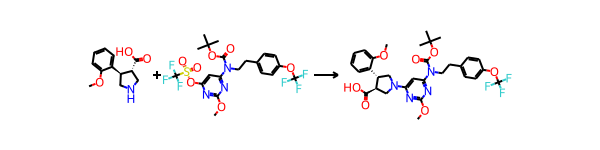

In [32]:
from rdkit.Chem import AllChem, rdChemReactions
test1= unsolve_unique[5]
display(rdChemReactions.ReactionFromSmarts(test1['reactions'], useSmiles= True))


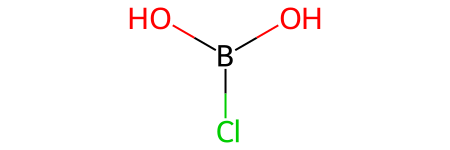

In [38]:
Chem.MolFromSmiles('B(O)(O)Cl')

In [9]:
pd.DataFrame(unsolve)['Diff_formula']
display(pd.DataFrame(pd.DataFrame(unsolve)['Diff_formula'].to_dict()).T.describe(include='all'))

0                                {'O': 1, 'Q': 0}
1                                {'O': 1, 'Q': 0}
2       {'Br': 1, 'O': 2, 'B': 1, 'H': 2, 'Q': 0}
3                                {'O': 1, 'Q': 0}
4                                {'O': 1, 'Q': 0}
                          ...                    
3793                             {'O': 1, 'Q': 0}
3794             {'O': 2, 'B': 1, 'H': 3, 'Q': 0}
3795                             {'O': 1, 'Q': 0}
3796                             {'O': 1, 'Q': 0}
3797                             {'O': 1, 'Q': 0}
Name: Diff_formula, Length: 3798, dtype: object

In [23]:
from SynRBL.rsmi_utils import save_database
import json
save_database(expected_result,'../Data/non_C.json')

In [3]:
from SynRBL.rsmi_utils import extract_results_by_key


solve, unsolve =extract_results_by_key(expected_result)
print('Solved:', len(solve))
print('Unsolved:', len(unsolve))

Solved: 28302
Unsolved: 3798


In [2]:
expected_result= load_database('../Data/non_C.json')

In [68]:
_, a =extract_results_by_key(expected_result)

b = remove_duplicates_by_key(a, lambda x: (x['Diff_formula']))
len(b)

4

In [78]:
b[3]

{'id': 'US07220863B2',
 'class': 9,
 'reactions': 'NNc1ncc(Cl)cc1F>>Nc1ncc(Cl)cc1F',
 'reactants': 'NNc1ncc(Cl)cc1F',
 'products': 'Nc1ncc(Cl)cc1F',
 'Unbalance': 'Products',
 'Diff_formula': {'N': 1, 'H': 1, 'Q': 0}}

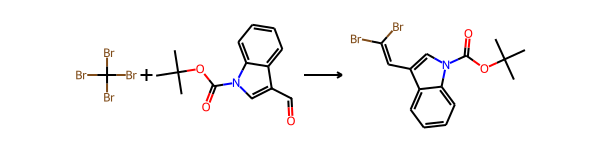

In [77]:
test1= b[2]
display(rdChemReactions.ReactionFromSmarts(test1['reactions'], useSmiles= True))


In [11]:
pd.DataFrame(solve)['Diff_formula'].drop_duplicates()

0                      {'O': 1, 'H': 2, 'Q': 0}
1                     {'Cl': 1, 'H': 1, 'Q': 0}
2     {'Br': 1, 'O': 2, 'B': 1, 'H': 2, 'Q': 0}
3                              {'H': 2, 'Q': 0}
5                     {'Br': 1, 'H': 1, 'Q': 0}
9                      {'F': 1, 'H': 1, 'Q': 0}
13                           {'Br': 1, 'Q': -1}
30     {'I': 1, 'O': 2, 'B': 1, 'H': 2, 'Q': 0}
36    {'Cl': 1, 'O': 2, 'B': 1, 'H': 2, 'Q': 0}
43                     {'F': 1, 'H': 2, 'Q': 1}
68                    {'I': 1, 'Br': 1, 'Q': 0}
88            {'O': 1, 'Br': 1, 'H': 3, 'Q': 0}
Name: Diff_formula, dtype: object

In [30]:
solve_unique[-3]

{'id': 'US07820704B2',
 'class': 3,
 'reactions': 'Clc1nccc(NC2CCCC2)n1.OB(O)c1ccc(OCc2ccccc2)cc1>>c1ccc(COc2ccc(-c3nccc(NC4CCCC4)n3)cc2)cc1',
 'reactants': 'Clc1nccc(NC2CCCC2)n1.OB(O)c1ccc(OCc2ccccc2)cc1',
 'products': 'c1ccc(COc2ccc(-c3nccc(NC4CCCC4)n3)cc2)cc1.B(O)(O)Cl',
 'Unbalance': 'Products',
 'Diff_formula': {'Cl': 1, 'O': 2, 'B': 1, 'H': 2, 'Q': 0},
 'new_reaction': 'Clc1nccc(NC2CCCC2)n1.OB(O)c1ccc(OCc2ccccc2)cc1>>c1ccc(COc2ccc(-c3nccc(NC4CCCC4)n3)cc2)cc1.B(O)(O)Cl'}

In [33]:
def remove_duplicates_by_diff_formula(data):
    """
    Remove duplicate entries from a list based on the 'Diff_formula' key of each entry, 
    while considering the entire dictionary for uniqueness.

    Parameters:
    data (list): A list of data entries, where each entry is a dictionary.

    Returns:
    list: A list of unique entries, based on the 'Diff_formula' keys and overall dictionary structure.

    Example:
    >>> data = [{'id': '1', 'Diff_formula': {'C': 8, 'O': 2}}, {'id': '2', 'Diff_formula': {'C': 8, 'O': 2}}]
    >>> remove_duplicates_by_diff_formula(data)
    [{'id': '1', 'Diff_formula': {'C': 8, 'O': 2}}]
    """

    seen_formulas = set()
    unique_data = []

    for entry in data:
        # Create a composite key consisting of the sorted 'Diff_formula' and other key-value pairs
        composite_key = (tuple(sorted(entry.get('Diff_formula', {}).items())),) + tuple(sorted((k, v) for k, v in entry.items() if k != 'Diff_formula'))

        if composite_key not in seen_formulas:
            seen_formulas.add(composite_key)
            unique_data.append(entry)

    return unique_data



solve_unique = remove_duplicates_by_key(solve, lambda x: (x['Diff_formula']))
len(solve_unique)

11

In [34]:
solve

[{'id': 'US20120114765A1',
  'class': 2,
  'reactions': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1>>O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1',
  'reactants': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1',
  'products': 'O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1.O',
  'Unbalance': 'Products',
  'Diff_formula': {'O': 1, 'H': 2, 'Q': 0},
  'new_reaction': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1>>O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1.O'},
 {'id': 'US08188098B2',
  'class': 2,
  'reactions': 'CCOc1ccc(Oc2ncnc3c2cnn3C2CCNCC2)c(F)c1.O=C(Cl)OC1CCCC1>>CCOc1ccc(Oc2ncnc3c2cnn3C2CCN(C(=O)OC3CCCC3)CC2)c(F)c1',
  'reactants': 'CCOc1ccc(Oc2ncnc3c2cnn3C2CCNCC2)c(F)c1.O=C(Cl)OC1CCCC1',
  'products': 'CCOc1ccc(Oc2ncnc3c2cnn3C2CCN(C(=O)OC3CCCC3)CC2)c(F)c1.Cl',
  'Unbalance': 'Products',
  'Diff_formula': {'Cl': 1, 'H': 1, 'Q': 0},
  'new_reaction': 'CCOc1ccc(Oc2ncnc3c2cnn3C2CCNCC2)c(F)c1.O=C(

In [6]:
from SynRBL.rsmi_utils import remove_duplicates_by_key
solve_unique = remove_duplicates_by_key(solve, lambda x: (x['Diff_formula']))
len(solve_unique)

11

In [8]:
solve

[{'id': 'US20120114765A1',
  'class': 2,
  'reactions': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1>>O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1',
  'reactants': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1',
  'products': 'O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1.O',
  'Unbalance': 'Products',
  'Diff_formula': {'O': 1, 'H': 2, 'Q': 0},
  'new_reaction': 'Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1>>O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1.O'},
 {'id': 'US08188098B2',
  'class': 2,
  'reactions': 'CCOc1ccc(Oc2ncnc3c2cnn3C2CCNCC2)c(F)c1.O=C(Cl)OC1CCCC1>>CCOc1ccc(Oc2ncnc3c2cnn3C2CCN(C(=O)OC3CCCC3)CC2)c(F)c1',
  'reactants': 'CCOc1ccc(Oc2ncnc3c2cnn3C2CCNCC2)c(F)c1.O=C(Cl)OC1CCCC1',
  'products': 'CCOc1ccc(Oc2ncnc3c2cnn3C2CCN(C(=O)OC3CCCC3)CC2)c(F)c1.Cl',
  'Unbalance': 'Products',
  'Diff_formula': {'Cl': 1, 'H': 1, 'Q': 0},
  'new_reaction': 'CCOc1ccc(Oc2ncnc3c2cnn3C2CCNCC2)c(F)c1.O=C(

In [7]:
def remove_duplicates_by_key(data, key_function):
    """
    Remove duplicate entries from a list based on a unique key for each entry.

    Parameters:
    data (list): A list of data entries (dictionaries, objects, etc.).
    key_function (function): A function that takes an entry from `data` and returns a key for duplicate check.

    Returns:
    list: A list of unique entries, based on the unique keys generated.

    Example:
    >>> data = [{'name': 'Alice', 'age': 30}, {'name': 'Bob', 'age': 25}, {'name': 'Alice', 'age': 30}]
    >>> remove_duplicates_by_key(data, lambda x: (x['name'], x['age']))
    [{'name': 'Alice', 'age': 30}, {'name': 'Bob', 'age': 25}]
    """

    # Set to keep track of already seen keys
    seen_keys = set()
    unique_data = []

    for entry in data:
        # Generate a key for each entry using the provided key function
        key = frozenset(key_function(entry))
        # Add entry to unique_data if key hasn't been seen before
        if key not in seen_keys:
            seen_keys.add(key)
            unique_data.append(entry)

    return unique_data

# Stop here

## 4.2. Rule Imputation

In [12]:
from SynRBL.SynRuleImpute import SyntheticRuleMatcher, SyntheticRuleImputer

In [31]:
imp = SyntheticRuleImputer(rule_dict=rules)
dict_impute=imp.impute(missing_dict=reactions_clean[30:32])
dict_impute

IndexError: list index out of range

In [40]:
df_test = pd.DataFrame(reactions_clean)
df_test[(df_test['Unbalance']=='Products') | (df_test['Unbalance']=='Reactions')]

,id,class,reactions,reactants,products,Unbalance,Diff_formula
0,US05849732,6,COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(...,COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(...,COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O,Products,"{'C': 8, 'O': 2, 'H': 6}"
1,US20120114765A1,2,Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c...,Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c...,O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(C...,Products,"{'O': 1, 'H': 2}"
2,US08003648B2,1,CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC...,CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC...,CCN(CC)Cc1ccc(-c2nc(C)c(COc3ccc([C@H](CC(=O)N4...,Products,{'O': 1}
3,US09045475B2,1,CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...,CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...,CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...,Products,{'O': 1}
4,US08188098B2,2,CCOc1ccc(Oc2ncnc3c2cnn3C2CCNCC2)c(F)c1.O=C(Cl)...,CCOc1ccc(Oc2ncnc3c2cnn3C2CCNCC2)c(F)c1.O=C(Cl)...,CCOc1ccc(Oc2ncnc3c2cnn3C2CCN(C(=O)OC3CCCC3)CC2...,Products,"{'Cl': 1, 'H': 1}"
...,...,...,...,...,...,...,...
50009,US20120065257A1,9,BrCC1COc2ccccc2O1.[C-]#N>>N#CCC1COc2ccccc2O1,BrCC1COc2ccccc2O1.[C-]#N,N#CCC1COc2ccccc2O1,Products,"{'Br': 1, 'Q': -1}"
50010,US20090028925A1,9,BrC(Br)(Br)Br.COCOc1ccc(Cc2c(C)cc(CO)cc2C)cc1C...,BrC(Br)(Br)Br.COCOc1ccc(Cc2c(C)cc(CO)cc2C)cc1C...,COCOc1ccc(Cc2c(C)cc(CBr)cc2C)cc1Cc1ccc(F)cc1,Products,"{'Br': 3, 'C': 1, 'O': 1, 'H': 1}"
50011,US20140194411A1,9,CCOC(=O)N1CCc2ccc3c(c2CC1)C(O)(C1CC1)CC3>>CCOC...,CCOC(=O)N1CCc2ccc3c(c2CC1)C(O)(C1CC1)CC3,CCOC(=O)N1CCc2ccc3c(c2CC1)C(C1CC1)CC3,Products,{'O': 1}
50012,US20090149445A1,9,Brc1cccc(C=C2c3ccccc3CCc3ccccc32)c1.N#C[Cu]>>N...,Brc1cccc(C=C2c3ccccc3CCc3ccccc32)c1.N#C[Cu],N#Cc1cccc(C=C2c3ccccc3CCc3ccccc32)c1,Products,"{'Br': 1, 'Cu': 1}"


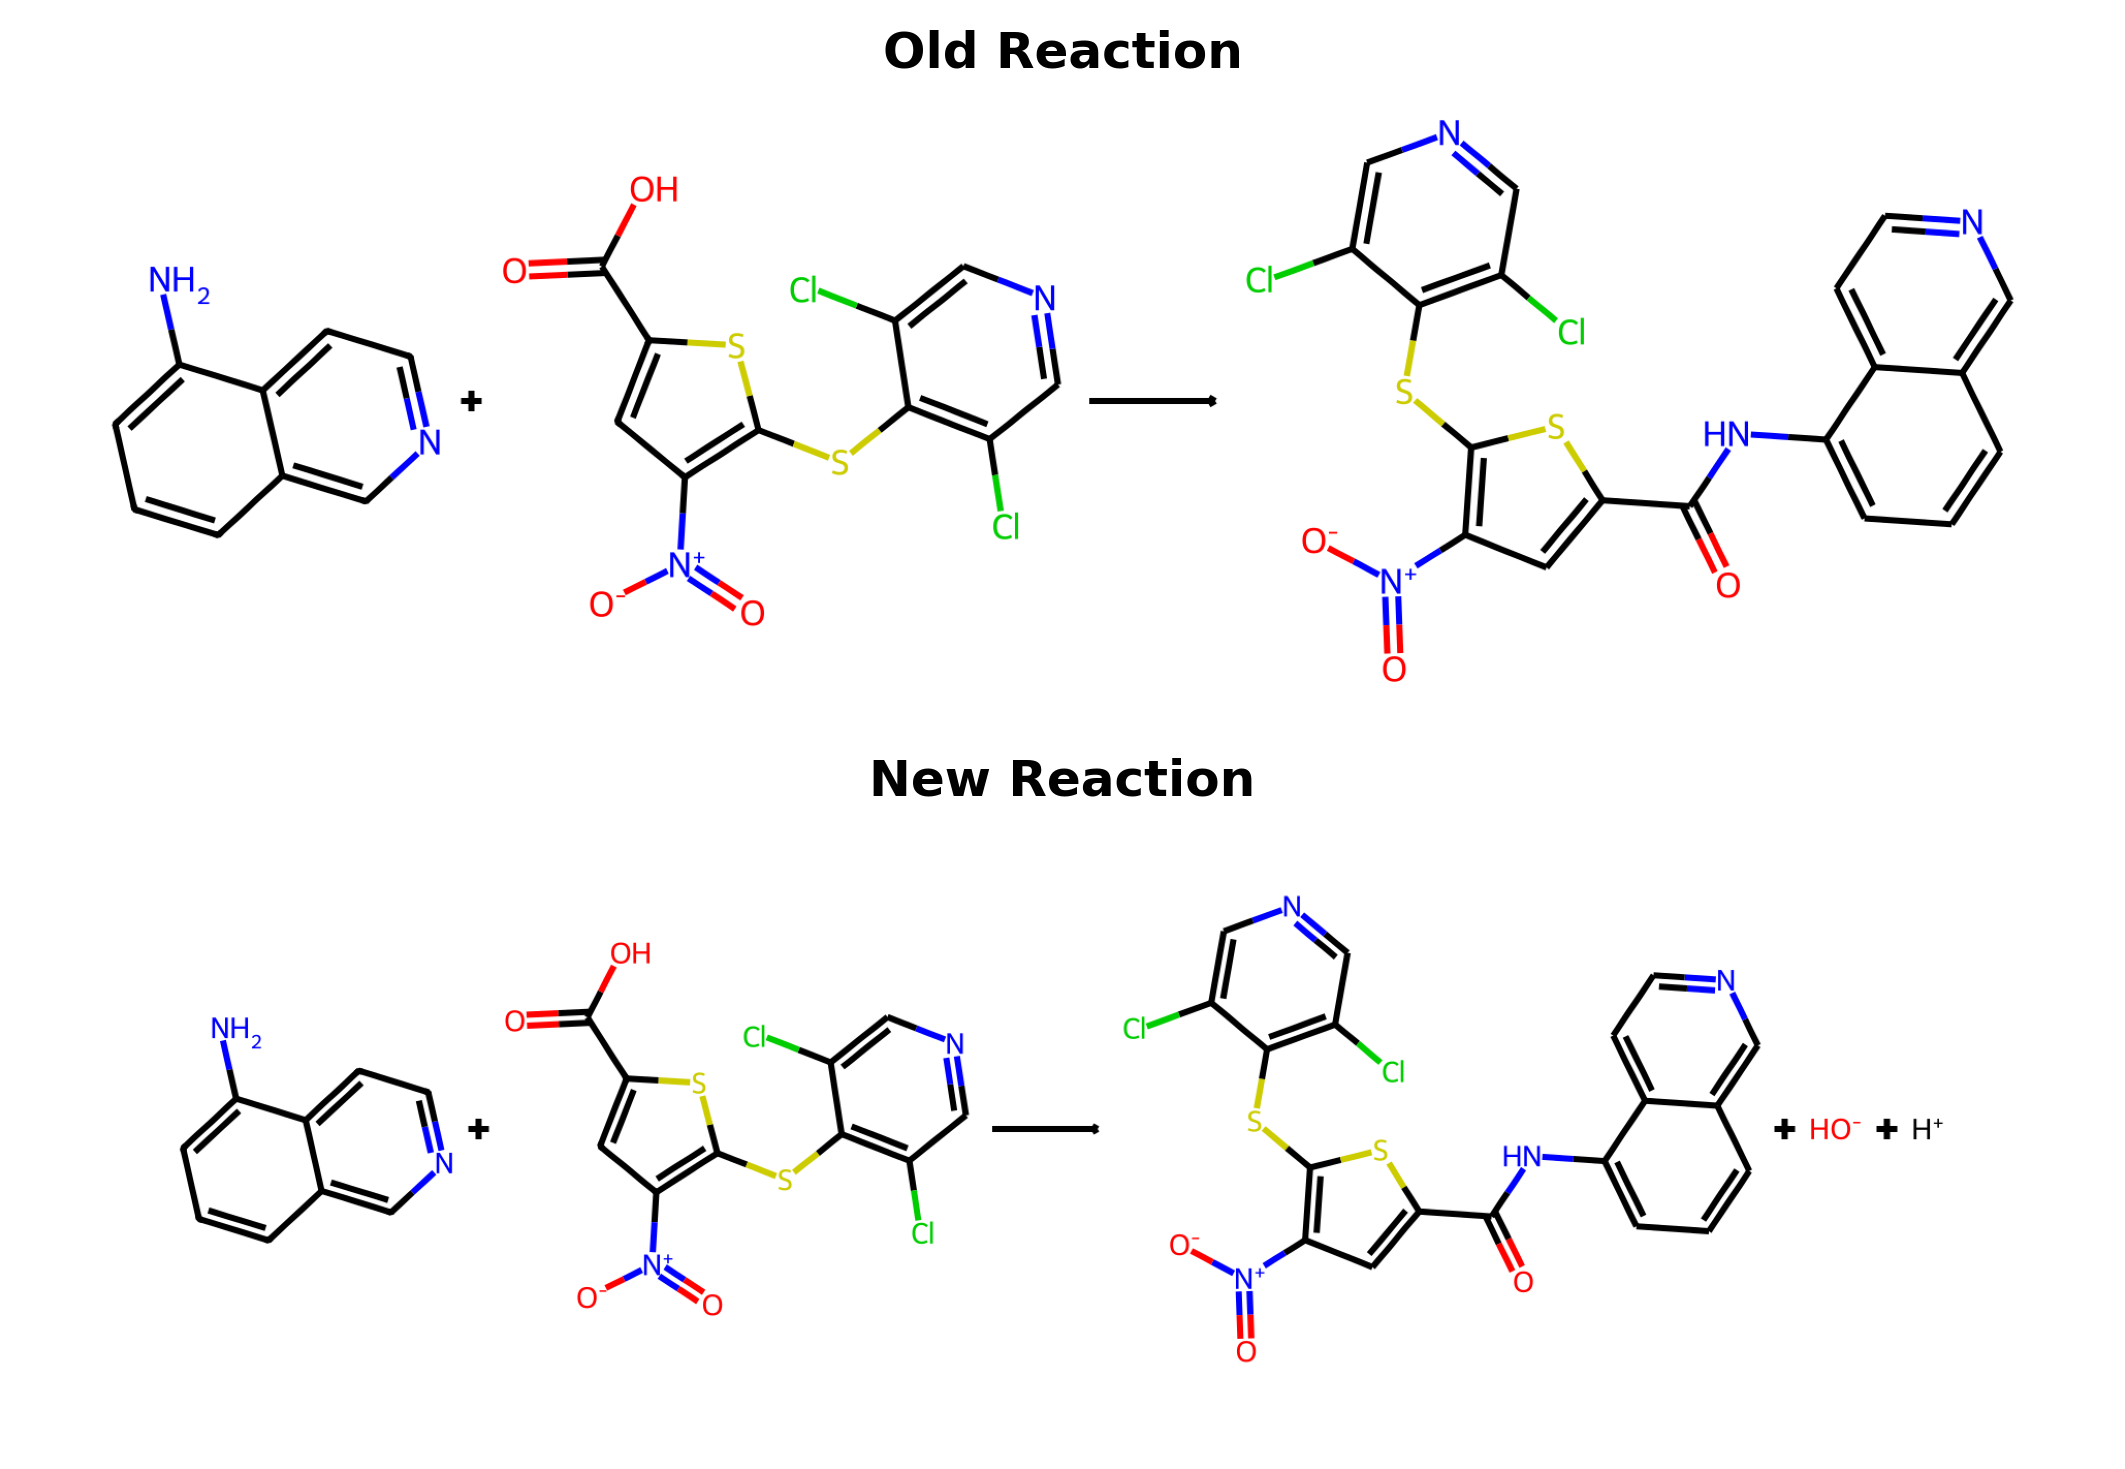

In [46]:
from SynRBL.SynVis import ReactionVisualizer

vis = ReactionVisualizer()
vis.plot_reactions(old_reaction_str=dict_impute[0]['reactions'], new_reaction_str=dict_impute[0]['new_reaction'], 
                   savefig=True, pathname = './Image/Reaction.png', dpi = 600)

## 4.3. Postprocessing 

### 4.3.1. FormulaSimilarityFinder

In [1]:
from SynRBL.SynRuleImpute import FormulaSimilarityFinder

In [2]:
# Example usage
pen = {'formula': 'C5H12O', 'smiles': 'CCCCCO'}
spen = {'formula': 'C5H12O', 'smiles': 'CCCC(O)C'}
pen_3 = {'formula': 'C5H12O', 'smiles': 'CCC(O)CC'}
tpen = {'formula': 'C5H12O', 'smiles': 'CC(O)(C)CC'}
ipen = {'formula': 'C5H12O', 'smiles': 'CC(C)CCO'}
neopen = {'formula': 'C5H12O', 'smiles': 'CC(C)(C)CO'}
ref_smiles = 'CC(C)CCOC(C)=O'

hit_molecules = [pen, spen, pen_3, tpen, ipen, neopen]
fingerprint_types = ['ecfp4', 'rdk5', 'maccs', 'map4', 'avalon']

similarity_calculator = FormulaSimilarityFinder(ref_smiles, hit_molecules)
most_similar_molecule = similarity_calculator.get_most_similar_molecule(fingerprint_types, 'hard')
print("Most similar molecule:", most_similar_molecule)


Most similar molecule: {'formula': 'C5H12O', 'smiles': 'CC(C)CCO'}


### 4.3.2. MCSfinder

In [31]:
from SynRBL.SynRuleImpute import MCSFinder

In [32]:
# Example usage
ref_smiles = 'CC(C)CCOC(C)=O'
hit_molecules = [
    {'formula': 'C5H12O', 'smiles': 'CCCCCO'},
    {'formula': 'C5H12O', 'smiles': 'CCCC(O)C'},
    {'formula': 'C5H12O', 'smiles': 'CCC(O)CC'},
    {'formula': 'C5H12O', 'smiles': 'CC(O)(C)CC'},
    {'formula': 'C5H12O', 'smiles': 'CC(C)CCO'},
    {'formula': 'C5H12O', 'smiles': 'CC(C)(C)CO'}
]

mcs_finder = MCSFinder(ref_smiles)

# RDKit's native MCS method
print("RDKit's native MCS method:")
for hit_molecule in hit_molecules:
    mcs_info = mcs_finder.get_mcs_info(hit_molecule['smiles'])
    print(f"RDKit MCS with {hit_molecule['smiles']}: Size = {mcs_info['size']}, SMILES = {mcs_info['smiles']}")

# Graph-based approach with RDKit's molecule-to-graph conversion
print("\nGraph-based approach with RDKit's molecule-to-graph conversion:")
for hit_molecule in hit_molecules:
    mcs_info = mcs_finder.get_mcs_info(hit_molecule['smiles'], use_graph=True)
    print(f"Graph MCS with {hit_molecule['smiles']} using RDKit: Size = {mcs_info['size']}")

# Graph-based approach with pysmiles, ignoring atom and bond types
print("\nGraph-based approach with pysmiles, ignoring atom and bond types:")
for hit_molecule in hit_molecules:
    mcs_info = mcs_finder.get_mcs_info(hit_molecule['smiles'], use_graph=True, use_pysmiles=True)
    print(f"Graph MCS with {hit_molecule['smiles']} using pysmiles: Size = {mcs_info['size']}")

RDKit's native MCS method:
RDKit MCS with CCCCCO: Size = 5, SMILES = [#6]-[#6]-[#6]-[#6]-[#8]
RDKit MCS with CCCC(O)C: Size = 5, SMILES = [#6]-[#6]-[#6]-[#6]-[#8]
RDKit MCS with CCC(O)CC: Size = 4, SMILES = [#6]-[#6]-[#6]-[#8]
RDKit MCS with CC(O)(C)CC: Size = 5, SMILES = [#6]-[#6](-[#6])-[#6]-[#6]
RDKit MCS with CC(C)CCO: Size = 6, SMILES = [#6]-[#6](-[#6])-[#6]-[#6]-[#8]
RDKit MCS with CC(C)(C)CO: Size = 4, SMILES = [#6]-[#6](-[#6])-[#6]

Graph-based approach with RDKit's molecule-to-graph conversion:
Graph MCS with CCCCCO using RDKit: Size = 0
Graph MCS with CCCC(O)C using RDKit: Size = 0
Graph MCS with CCC(O)CC using RDKit: Size = 0
Graph MCS with CC(O)(C)CC using RDKit: Size = 0
Graph MCS with CC(C)CCO using RDKit: Size = 6
Graph MCS with CC(C)(C)CO using RDKit: Size = 0

Graph-based approach with pysmiles, ignoring atom and bond types:
Graph MCS with CCCCCO using pysmiles: Size = 0
Graph MCS with CCCC(O)C using pysmiles: Size = 0
Graph MCS with CCC(O)CC using pysmiles: Size = 0
G

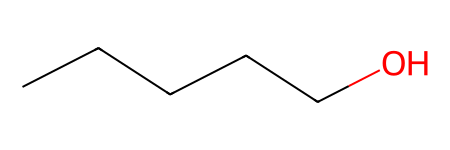

In [2]:
from rdkit import Chem
Chem.MolFromSmiles('CCCCCO')

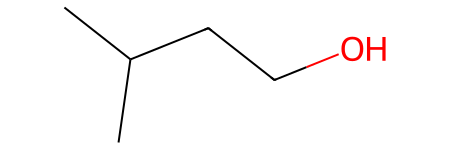

In [3]:
Chem.MolFromSmiles('CC(C)CCO')